# Optimizating Metalens with Near-to-Far Fields

The adjoint solver in meep now supports the adjoint simulation for near-to-far fields transformation. A simple optimization of metalens is presented below to demonstrate its usage.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

We define the computational cell, and the frequencies of interest. This example only involves single frequency, but optimization problem involving several frequencies is also supported. 

In [2]:
design_region_width = 32
design_region_height = 2

pml_size = 1.0

resolution = 30

Sx = design_region_width
Sy = 2*pml_size + design_region_height + 5
cell_size = mp.Vector3(Sx,Sy)

frequencies = np.array([1/1.55])

As before, we'll specify our smoothing filter, design regions, and simulations etc. However, we don't need masks in this setup.

In [3]:
minimum_length = 0.09 # minimum length scale (microns)
eta_i = 0.5 # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55 # erosion design field thresholding point (between 0 and 1)
eta_d = 1-eta_e # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)
print(filter_radius)
design_region_resolution = int(1*resolution)

0.20124611797498096


In [4]:
pml_layers = [mp.PML(pml_size, direction=mp.Y)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [0,-(design_region_height/2 + 1.5),0]
source_size    = mp.Vector3(Sx,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    size = source_size,
                    center=source_center)]

In [5]:
Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_SUM')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0)))

In [6]:
def mapping(x,eta,beta):
    # filter
    filtered_field = mpa.conic_filter(x,filter_radius,design_region_width,design_region_height,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    # interpolate to actual materials
    return projected_field.flatten()

We will enforce a symmetry as before, but across the $x=0$ axis in this case. Thus, we can use `symmetries=[mp.Mirror(direction=mp.X)]` when defining simulation to speed up the computation.

In [7]:
geometry = [
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables),
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables, e1=mp.Vector3(x=-1))] # design region
kpoint = mp.Vector3()
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    k_point=kpoint,
                    geometry=geometry,
                    sources=source,
                    default_material=SiO2,
                    symmetries=[mp.Mirror(direction=mp.X)],
                    resolution=resolution)

The adjoint solver for near2far transform only accepts one single far field point right now, but support for multiple points will be avaible soon. We also need to provide a near-field monitor, from which the field at far point will be calculated. Only single monitor is supported right now, so the monitor needs to extend to the entire cell to capture all outgoing fields.

When evaluated, mpa.Near2FarFields will return nfreq by 6 numpy array, where the second axis corresponds to the field components $E_x, E_y, E_z, H_x, H_y, H_z$, in that order. We will specify a objective as a function of the field components at frequencies of interest. In this case, we would like to optimize $|E_z|^2$ at the single given frequency

In [8]:
far_x = mp.Vector3(0,40,0)
NearRegions = [mp.Near2FarRegion(center=mp.Vector3(0,design_region_height/2+1.5), size=mp.Vector3(design_region_width+1.5,0), weight=+1)]
FarFields = mpa.Near2FarFields(sim, NearRegions ,far_x)
ob_list = [FarFields]
def J(alpha):
    return npa.abs(alpha[0,2])**2

We specified an additional maximum_run_time, at which the fields will have converged, but the decay_by factor hasn't been reached due to some small oscillations.

In [9]:
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies,
    decay_by = 1e-4,
    decay_fields=[mp.Ez],
    maximum_run_time = 2000
)

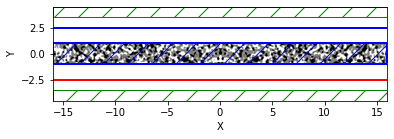

In [10]:
rho_vector = np.random.rand(Nx*Ny)
opt.update_design([mapping(rho_vector,eta_i,1e3)])
opt.plot2D(True)
plt.show()

We will define the cost function and run the optimizer as before. Note that for a single frequency problem, we need to use `dJ_du` instead of `np.sum(dJ_du,axis=1)` when calculating the gradient.

Be aware that the entire optimization below will take about 10-15 hours to run.

In [11]:
evaluation_history = []
cur_iter = [0]
def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0]+1))
    
    f0, dJ_du = opt([mapping(v,eta_i,cur_beta)]) # compute objective and gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping,0)(v,eta_i,cur_beta,dJ_du) # backprop
    
    
    evaluation_history.append(np.real(f0))
    
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
    circ = Circle((2,2),minimum_length/2)
    ax.add_patch(circ)
    ax.axis('off')
    #plt.savefig('media/bend_{:03d}.png'.format(cur_iter[0]),dpi=300)
    plt.show()
    
    cur_iter[0] = cur_iter[0] + 1
    
    return np.real(f0)

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...


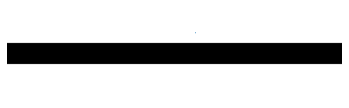

Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


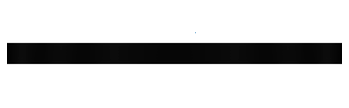

Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


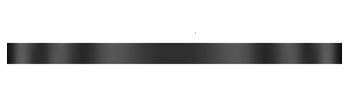

Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


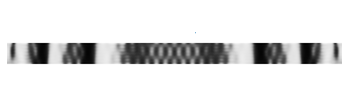

Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...


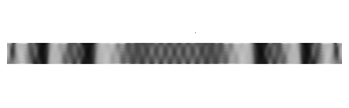

Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...


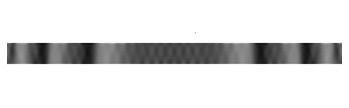

Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...


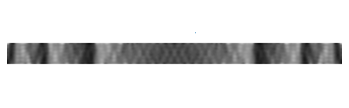

Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


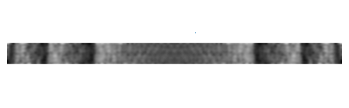

Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...


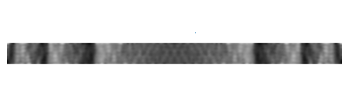

Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...


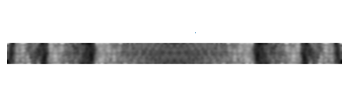

Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...


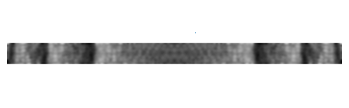

Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...


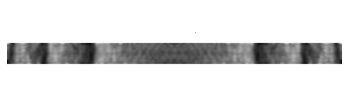

Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...


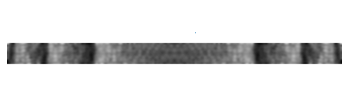

Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...


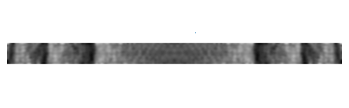

Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...


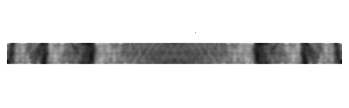

Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


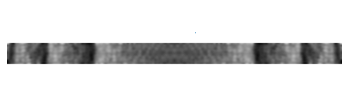

Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...


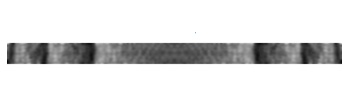

Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...


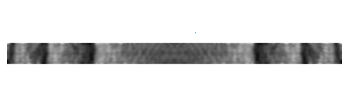

Current iteration: 19
Starting forward run...
Starting adjoint run...
Calculating gradient...


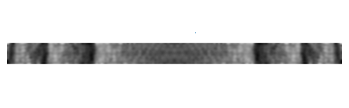

Current iteration: 20
Starting forward run...
Starting adjoint run...
Calculating gradient...


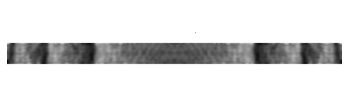

Current iteration: 21
Starting forward run...
Starting adjoint run...
Calculating gradient...


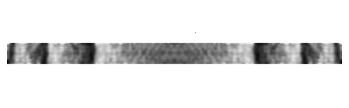

Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...


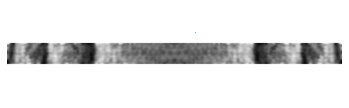

Current iteration: 23
Starting forward run...
Starting adjoint run...
Calculating gradient...


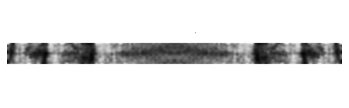

Current iteration: 24
Starting forward run...
Starting adjoint run...
Calculating gradient...


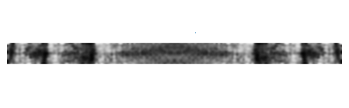

Current iteration: 25
Starting forward run...
Starting adjoint run...
Calculating gradient...


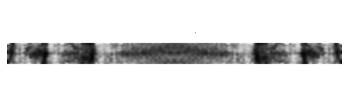

Current iteration: 26
Starting forward run...
Starting adjoint run...
Calculating gradient...


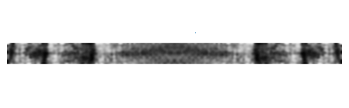

Current iteration: 27
Starting forward run...
Starting adjoint run...
Calculating gradient...


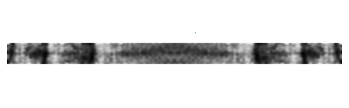

Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...


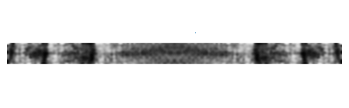

Current iteration: 29
Starting forward run...
Starting adjoint run...
Calculating gradient...


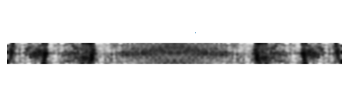

Current iteration: 30
Starting forward run...
Starting adjoint run...
Calculating gradient...


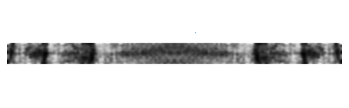

Current iteration: 31
Starting forward run...
Starting adjoint run...
Calculating gradient...


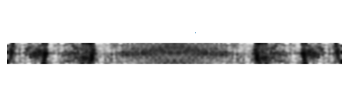

Current iteration: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


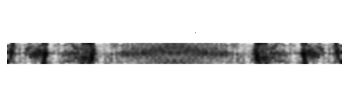

Current iteration: 33
Starting forward run...
Starting adjoint run...
Calculating gradient...


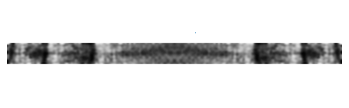

Current iteration: 34
Starting forward run...
Starting adjoint run...
Calculating gradient...


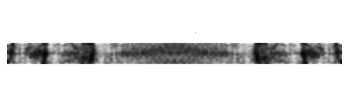

Current iteration: 35
Starting forward run...
Starting adjoint run...
Calculating gradient...


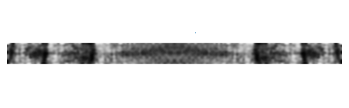

Current iteration: 36
Starting forward run...
Starting adjoint run...
Calculating gradient...


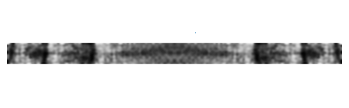

Current iteration: 37
Starting forward run...
Starting adjoint run...
Calculating gradient...


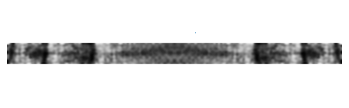

Current iteration: 38
Starting forward run...
Starting adjoint run...
Calculating gradient...


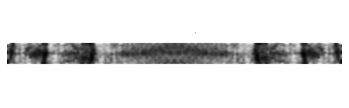

Current iteration: 39
Starting forward run...
Starting adjoint run...
Calculating gradient...


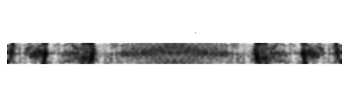

Current iteration: 40
Starting forward run...
Starting adjoint run...
Calculating gradient...


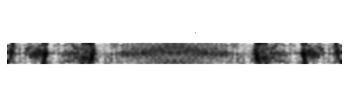

Current iteration: 41
Starting forward run...
Starting adjoint run...
Calculating gradient...


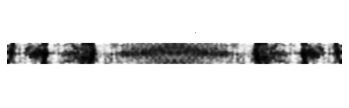

Current iteration: 42
Starting forward run...
Starting adjoint run...
Calculating gradient...


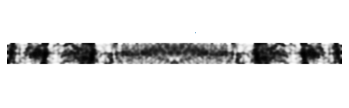

Current iteration: 43
Starting forward run...
Starting adjoint run...
Calculating gradient...


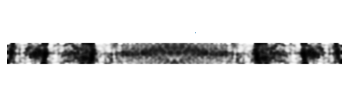

Current iteration: 44
Starting forward run...
Starting adjoint run...
Calculating gradient...


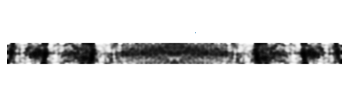

Current iteration: 45
Starting forward run...
Starting adjoint run...
Calculating gradient...


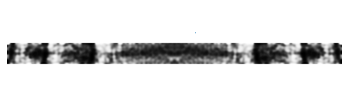

Current iteration: 46
Starting forward run...
Starting adjoint run...
Calculating gradient...


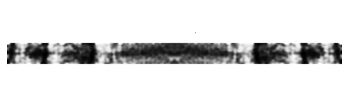

Current iteration: 47
Starting forward run...
Starting adjoint run...
Calculating gradient...


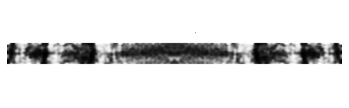

Current iteration: 48
Starting forward run...
Starting adjoint run...
Calculating gradient...


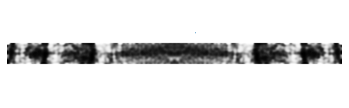

Current iteration: 49
Starting forward run...
Starting adjoint run...
Calculating gradient...


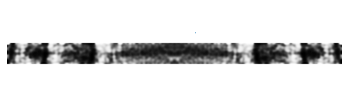

Current iteration: 50
Starting forward run...
Starting adjoint run...
Calculating gradient...


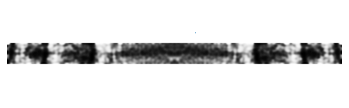

Current iteration: 51
Starting forward run...
Starting adjoint run...
Calculating gradient...


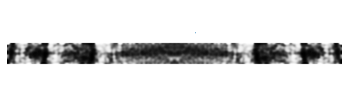

Current iteration: 52
Starting forward run...
Starting adjoint run...
Calculating gradient...


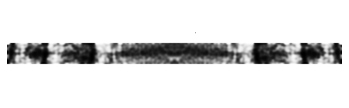

Current iteration: 53
Starting forward run...
Starting adjoint run...
Calculating gradient...


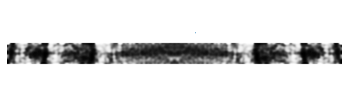

Current iteration: 54
Starting forward run...
Starting adjoint run...
Calculating gradient...


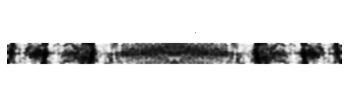

Current iteration: 55
Starting forward run...
Starting adjoint run...
Calculating gradient...


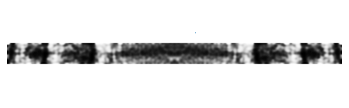

Current iteration: 56
Starting forward run...
Starting adjoint run...
Calculating gradient...


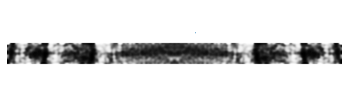

Current iteration: 57
Starting forward run...
Starting adjoint run...
Calculating gradient...


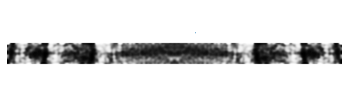

Current iteration: 58
Starting forward run...
Starting adjoint run...
Calculating gradient...


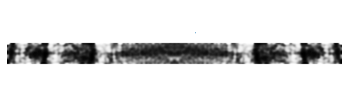

Current iteration: 59
Starting forward run...
Starting adjoint run...
Calculating gradient...


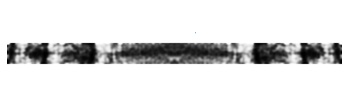

Current iteration: 60
Starting forward run...
Starting adjoint run...
Calculating gradient...


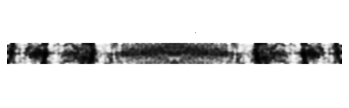

Current iteration: 61
Starting forward run...
Starting adjoint run...
Calculating gradient...


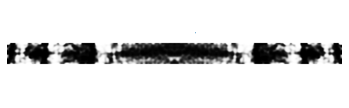

Current iteration: 62
Starting forward run...
Starting adjoint run...
Calculating gradient...


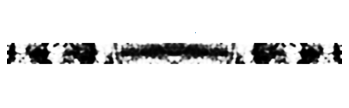

Current iteration: 63
Starting forward run...
Starting adjoint run...
Calculating gradient...


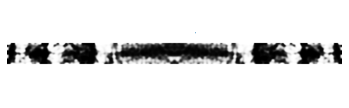

Current iteration: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


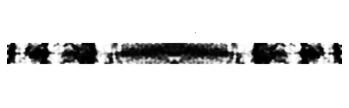

Current iteration: 65
Starting forward run...
Starting adjoint run...
Calculating gradient...


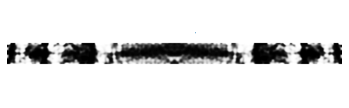

Current iteration: 66
Starting forward run...
Starting adjoint run...
Calculating gradient...


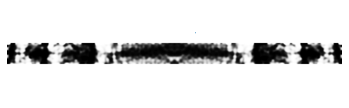

Current iteration: 67
Starting forward run...
Starting adjoint run...
Calculating gradient...


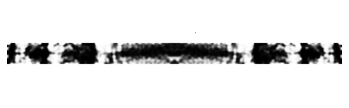

Current iteration: 68
Starting forward run...
Starting adjoint run...
Calculating gradient...


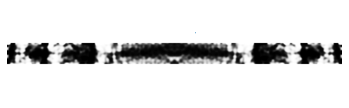

Current iteration: 69
Starting forward run...
Starting adjoint run...
Calculating gradient...


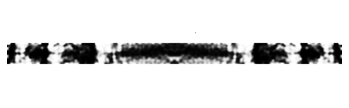

Current iteration: 70
Starting forward run...
Starting adjoint run...
Calculating gradient...


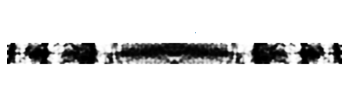

Current iteration: 71
Starting forward run...
Starting adjoint run...
Calculating gradient...


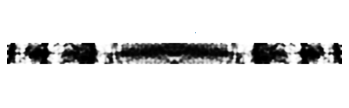

Current iteration: 72
Starting forward run...
Starting adjoint run...
Calculating gradient...


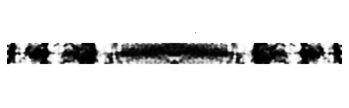

Current iteration: 73
Starting forward run...
Starting adjoint run...
Calculating gradient...


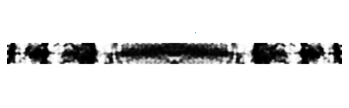

Current iteration: 74
Starting forward run...
Starting adjoint run...
Calculating gradient...


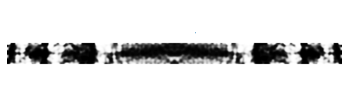

Current iteration: 75
Starting forward run...
Starting adjoint run...
Calculating gradient...


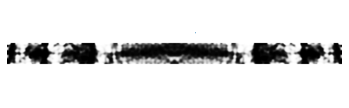

Current iteration: 76
Starting forward run...
Starting adjoint run...
Calculating gradient...


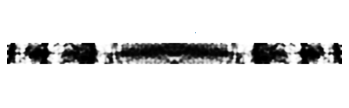

Current iteration: 77
Starting forward run...
Starting adjoint run...
Calculating gradient...


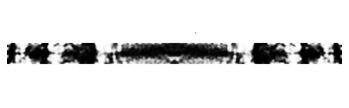

Current iteration: 78
Starting forward run...
Starting adjoint run...
Calculating gradient...


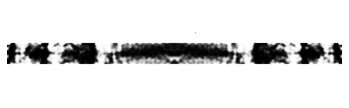

Current iteration: 79
Starting forward run...
Starting adjoint run...
Calculating gradient...


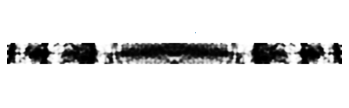

Current iteration: 80
Starting forward run...
Starting adjoint run...
Calculating gradient...


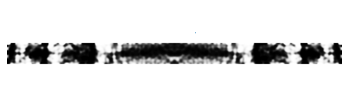

Current iteration: 81
Starting forward run...
Starting adjoint run...
Calculating gradient...


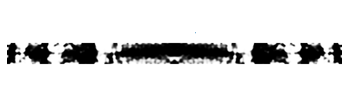

Current iteration: 82
Starting forward run...
Starting adjoint run...
Calculating gradient...


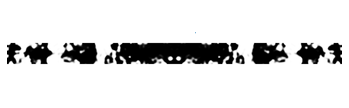

Current iteration: 83
Starting forward run...
Starting adjoint run...
Calculating gradient...


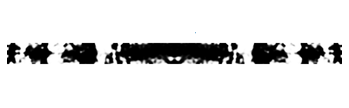

Current iteration: 84
Starting forward run...
Starting adjoint run...
Calculating gradient...


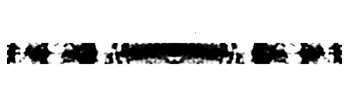

Current iteration: 85
Starting forward run...
Starting adjoint run...
Calculating gradient...


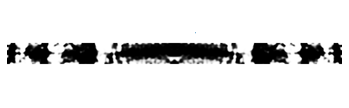

Current iteration: 86
Starting forward run...
Starting adjoint run...
Calculating gradient...


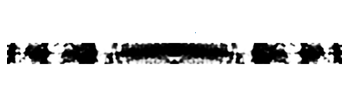

Current iteration: 87
Starting forward run...
Starting adjoint run...
Calculating gradient...


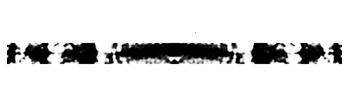

Current iteration: 88
Starting forward run...
Starting adjoint run...
Calculating gradient...


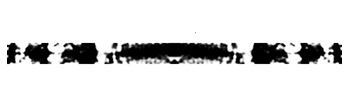

Current iteration: 89
Starting forward run...
Starting adjoint run...
Calculating gradient...


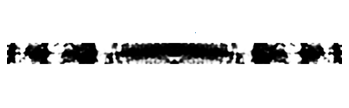

Current iteration: 90
Starting forward run...
Starting adjoint run...
Calculating gradient...


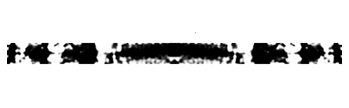

Current iteration: 91
Starting forward run...
Starting adjoint run...
Calculating gradient...


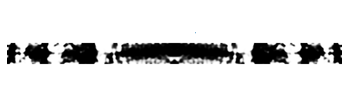

Current iteration: 92
Starting forward run...
Starting adjoint run...
Calculating gradient...


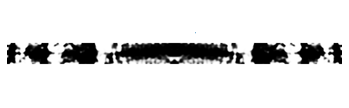

Current iteration: 93
Starting forward run...
Starting adjoint run...
Calculating gradient...


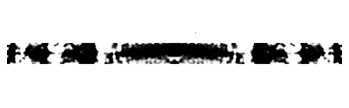

Current iteration: 94
Starting forward run...
Starting adjoint run...
Calculating gradient...


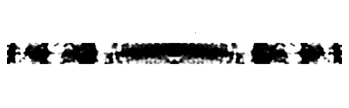

Current iteration: 95
Starting forward run...
Starting adjoint run...
Calculating gradient...


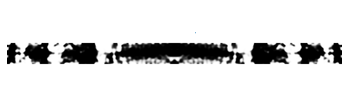

Current iteration: 96
Starting forward run...
Starting adjoint run...
Calculating gradient...


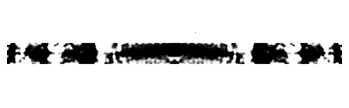

Current iteration: 97
Starting forward run...
Starting adjoint run...
Calculating gradient...


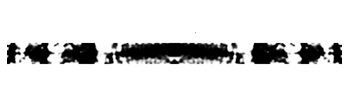

Current iteration: 98
Starting forward run...
Starting adjoint run...
Calculating gradient...


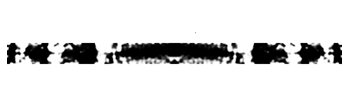

Current iteration: 99
Starting forward run...
Starting adjoint run...
Calculating gradient...


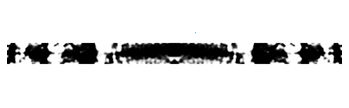

Current iteration: 100
Starting forward run...
Starting adjoint run...
Calculating gradient...


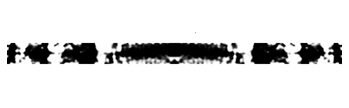

Current iteration: 101
Starting forward run...
Starting adjoint run...
Calculating gradient...


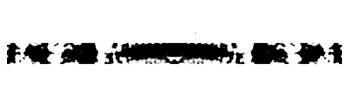

Current iteration: 102
Starting forward run...
Starting adjoint run...
Calculating gradient...


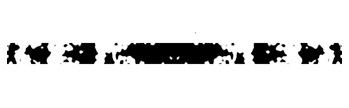

Current iteration: 103
Starting forward run...
Starting adjoint run...
Calculating gradient...


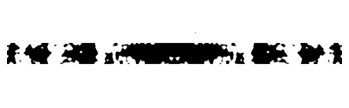

Current iteration: 104
Starting forward run...
Starting adjoint run...
Calculating gradient...


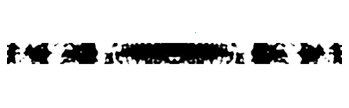

Current iteration: 105
Starting forward run...
Starting adjoint run...
Calculating gradient...


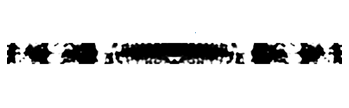

Current iteration: 106
Starting forward run...
Starting adjoint run...
Calculating gradient...


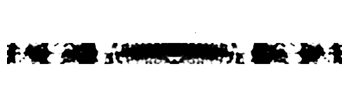

Current iteration: 107
Starting forward run...
Starting adjoint run...
Calculating gradient...


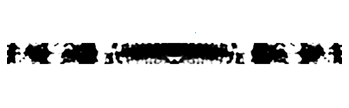

Current iteration: 108
Starting forward run...
Starting adjoint run...
Calculating gradient...


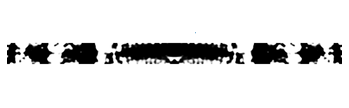

Current iteration: 109
Starting forward run...
Starting adjoint run...
Calculating gradient...


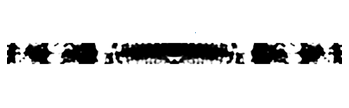

Current iteration: 110
Starting forward run...
Starting adjoint run...
Calculating gradient...


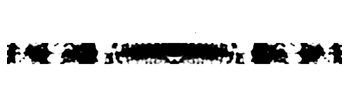

Current iteration: 111
Starting forward run...
Starting adjoint run...
Calculating gradient...


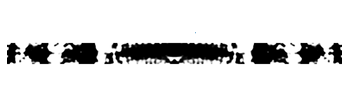

Current iteration: 112
Starting forward run...
Starting adjoint run...
Calculating gradient...


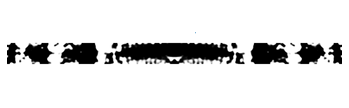

Current iteration: 113
Starting forward run...
Starting adjoint run...
Calculating gradient...


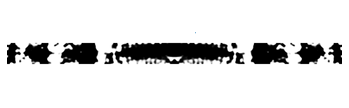

Current iteration: 114
Starting forward run...
Starting adjoint run...
Calculating gradient...


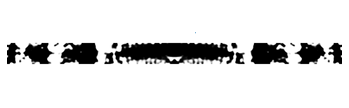

Current iteration: 115
Starting forward run...
Starting adjoint run...
Calculating gradient...


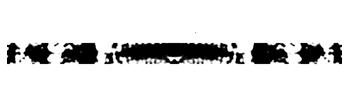

Current iteration: 116
Starting forward run...
Starting adjoint run...
Calculating gradient...


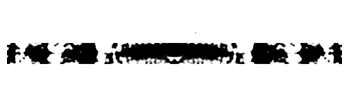

Current iteration: 117
Starting forward run...
Starting adjoint run...
Calculating gradient...


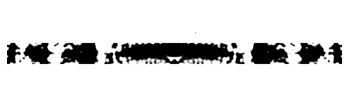

Current iteration: 118
Starting forward run...
Starting adjoint run...
Calculating gradient...


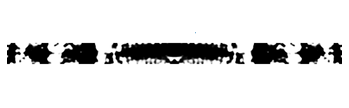

Current iteration: 119
Starting forward run...
Starting adjoint run...
Calculating gradient...


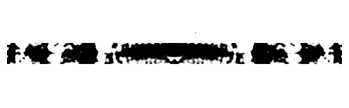

Current iteration: 120
Starting forward run...
Starting adjoint run...
Calculating gradient...


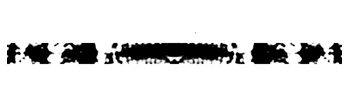

In [12]:
algorithm = nlopt.LD_MMA
n = Nx * Ny # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx*Ny,))
ub = np.ones((Nx*Ny,))

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 20
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a,g: f(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_xtol_rel(1e-4)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale

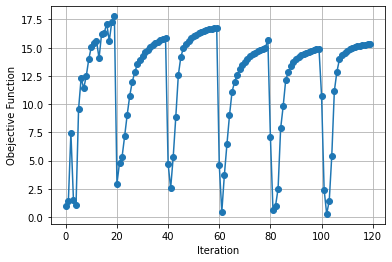

In [13]:
plt.figure()
plt.plot((evaluation_history),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Obejective Function')
plt.show()

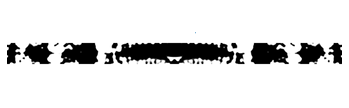

In [14]:
opt.update_design([mapping(x,eta_i,cur_beta)])
plt.figure()
ax = plt.gca()
opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
circ = Circle((2,2),minimum_length/2)
ax.add_patch(circ)
ax.axis('off')
plt.show()

To see the performance of our final structure, we use a CW source at the desired frequency and plot the fields after the struture. We can see that the metalens is trying to focus the field to some point far away, as we wanted.

<AxesSubplot:xlabel='X', ylabel='Y'>

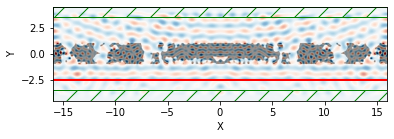

In [15]:
src = mp.ContinuousSource(frequency=1/1.55,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    size = source_size,
                    center=source_center)]
opt.sim.change_sources(source)
opt.sim.run(until=500)
opt.sim.plot2D(fields=mp.Ez)

We put the struture in a larger simulation cell to include the far field point, and ran the simulation to see how it behave directly.

<AxesSubplot:xlabel='X', ylabel='Y'>

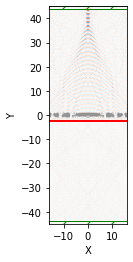

In [16]:
opt.sim = mp.Simulation(cell_size=mp.Vector3(Sx,90),
                    boundary_layers=pml_layers,
                    k_point=kpoint,
                    geometry=geometry,
                    sources=source,
                    default_material=SiO2,
                    resolution=resolution)
opt.sim.run(until=500)
opt.sim.plot2D(fields=mp.Ez)

We plot the figure with larger size. We can see the fields successfully focused on (40,0), as desired.

<AxesSubplot:xlabel='X', ylabel='Y'>

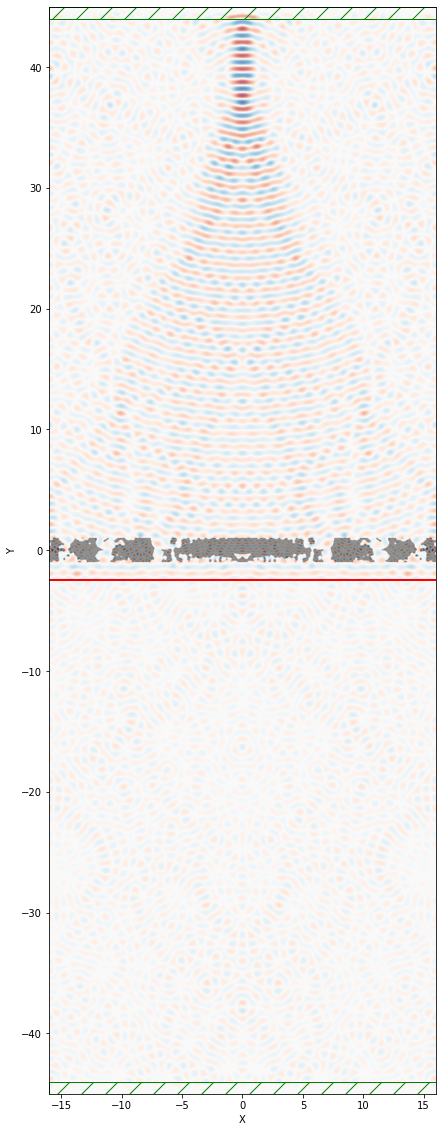

In [17]:
plt.figure(figsize=(10,20))
opt.sim.plot2D(fields=mp.Ez)